# Setup

In [28]:
url = 'http://3c9d-34-74-222-41.ngrok.io'
# url = 'http://35.232.59.3:8080'

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from zipfile import ZipFile
%matplotlib inline

# Evaluation Functions

In [8]:
def recall_at_k(true_list,predicted_list,k=40):   
      
    return round(len([i for i in predicted_list[:k] if i in true_list]) / len(true_list), 3)

In [9]:
def precision_at_k(true_list,predicted_list,k=40):     

    return round(len([i for i in predicted_list[:k] if i in true_list]) / k, 3)

In [10]:
def r_precision(true_list,predicted_list):

    return round(len([i for i in predicted_list[:len(true_list)] if i in true_list]) / len(true_list), 3)

In [12]:
def reciprocal_rank_at_k(true_list,predicted_list,k=40):

    ele = next((i for i, v in enumerate(predicted_list) if v in true_list), None)
    if ele == None or ele > (k - 1):
      return 0.000
    else:
      return round(1 / (ele + 1), 3)

In [13]:
def f_score(true_list,predicted_list,k=40):
    
    precision = precision_at_k(true_list,predicted_list,k)
    recall = recall_at_k(true_list,predicted_list,k)
    if precision == 0 and recall == 0:
      return 0
    else:
      return round((2 * precision * recall) / (precision + recall), 3)

In [14]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [15]:
def evaluate(true_relevancy,predicted_relevancy,k,print_scores=True):   

    recall_lst = []
    precision_lst = []
    f_score_lst = []
    r_precision_lst = []
    reciprocal_rank_lst = []
    avg_precision_lst = []
    metrices = {'recall@k':recall_lst,
                'precision@k':precision_lst,
                'f_score@k': f_score_lst,
                'r-precision': r_precision_lst,
                'MRR@k':reciprocal_rank_lst,
                'MAP@k':avg_precision_lst}

    for query, ground_true in true_relevancy:  
      predicted = predicted_relevancy[query]

      recall_lst.append(recall_at_k(ground_true,predicted,k=k))
      precision_lst.append(precision_at_k(ground_true,predicted,k=k))
      f_score_lst.append(f_score(ground_true,predicted,k=k))
      r_precision_lst.append(r_precision(ground_true,predicted))
      reciprocal_rank_lst.append(reciprocal_rank_at_k(ground_true,predicted,k=k))
      avg_precision_lst.append(average_precision(ground_true,predicted,k=k))

    if print_scores:
        for name,values in metrices.items():
                print(name,sum(values)/len(values))

    return metrices

In [16]:
def plot_metric_different_quieries(true_relevancy,predicted_relevancy,metrices_names,k):

    for metric_name in metrices_names:
      met = evaluate(true_relevancy,predicted_relevancy,k=k,print_scores=False)
      met_list = met[metric_name]
      plt.xlabel("Queries")
      plt.ylabel("Metric")
      plt.title(metric_name)
      plt.plot([i+1 for i in range(len(met_list))], met_list)
      plt.show()

# Test PageRank and PageViews

In [ ]:
import requests
from time import time

try:
  res = requests.post(url + '/get_pageview', json=[1, 3434750, 713, 1], timeout=35)
  if res.status_code == 200:
    pred_wids = res.json()
    print(pred_wids)
except:
  pass

try:
  res = requests.post(url + '/get_pagerank', json=[1, 3434750, 713, 1], timeout=35)
  if res.status_code == 200:
    pred_wids = res.json()
    print(pred_wids)
except:
  pass

# Test all queries with MAP

In [3]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [29]:
import requests
from time import time

qs_res = []
pred_wids = {}
sum_duration = 0
map25 = True
duration35 = True
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    sum_duration += duration
    if res.status_code == 200:
      pred_wids[q] = [tup[0] for tup in res.json()]
      ap = average_precision(true_wids, pred_wids[q])
      if ap < 0.25: map25 = False 
  except:
    pass
  
  if duration == None: duration35 = False
  qs_res.append((q, duration, ap))

In [30]:
print("Duration < 35s : " + str(duration35))
print("AP@40 > 0.25   : " + str(map25))
print("AVG Duration   : " + str(sum_duration/len(queries)) + "\n")
qs_res

Duration < 35s : True
AP@40 > 0.25   : False
AVG Duration   : 0.7737572908401489



[('python', 0.17801785469055176, 0.699),
 ('data science', 1.7569797039031982, 0.512),
 ('migraine', 0.11846494674682617, 0.963),
 ('chocolate', 0.1609659194946289, 0.614),
 ('how to make pasta', 1.1868431568145752, 0.569),
 ('Does pasta have preservatives?', 0.508617639541626, 0.128),
 ('how google works', 2.3732211589813232, 0.737),
 ('what is information retrieval', 0.9423794746398926, 0.831),
 ('NBA', 0.17486286163330078, 0.429),
 ('yoga', 0.14061927795410156, 0.548),
 ('how to not kill plants', 1.1951916217803955, 0.511),
 ('masks', 0.22275614738464355, 0.678),
 ('black friday', 0.8220555782318115, 0.832),
 ('why do men have nipples', 0.9248983860015869, 0.82),
 ('rubber duck', 0.25466227531433105, 0.922),
 ('michelin', 0.14816808700561523, 0.446),
 ('what to watch', 0.4505789279937744, 0.5),
 ('best marvel movie', 1.2909784317016602, 0.603),
 ('how tall is the eiffel tower', 0.5642039775848389, 0.746),
 ('where does vanilla flavoring come from', 0.8163595199584961, 0.725),
 ('bes

recall@k 0.1913
precision@k 0.38583333333333336
f_score@k 0.25453333333333333
r-precision 0.2749
MRR@k 0.8083333333333333
MAP@k 0.6164000000000001


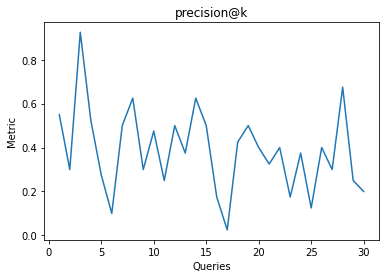

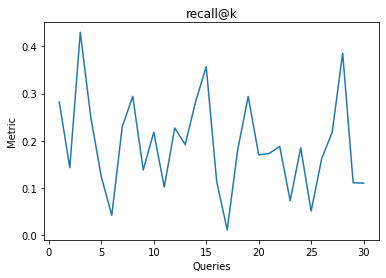

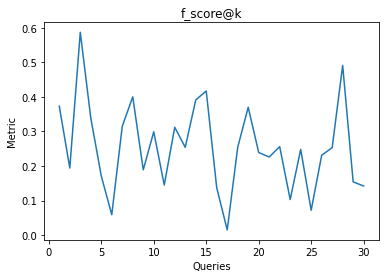

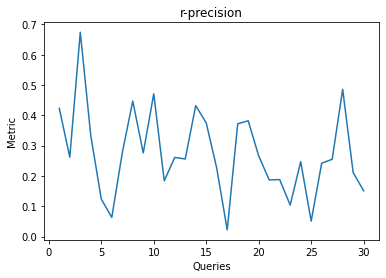

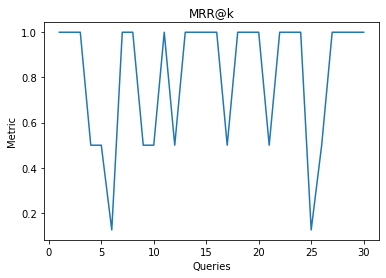

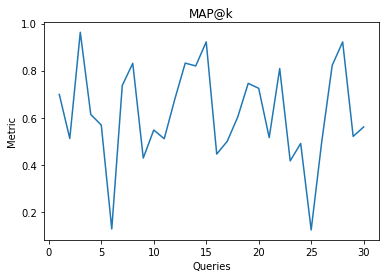

In [31]:
evaluate(queries.items(),pred_wids,k=40,print_scores=True)
plot_metric_different_quieries(queries.items(),pred_wids,['precision@k','recall@k','f_score@k','r-precision','MRR@k','MAP@k'],k=40)